In [29]:
'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd
import os

'''Visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

'''Implementation of Transfer Learning'''
from tensorflow.keras.applications import MobileNetV2

'''Image generation and preprocessing'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'''Result and Performance Analysis'''
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

'''Ignoring Warnings'''
import warnings
warnings.filterwarnings("ignore")


In [30]:
DIR = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' #Creating a master directory
classes = [i for i in os.listdir(DIR) if '.' not in i]                     #Creating classes out of the required folders
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [32]:
'''Since the GT images are of no use to us for the analysis, we will be separating them out of our directory'''

# Create a dataframe with a column which consists of all the filepaths (without GT) and its respective label as the other column

label = []
path = []

for dirname, _,filenames in os.walk(DIR):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dirname.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dirname)[-1])         # Append the directory name to label 
                path.append(os.path.join(dirname,filename))     # Append all the png files to path of that directory

# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [33]:
df.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [34]:
df.path[0]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png'

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [36]:
#Checking the value counts of each of the datasets
#df['label']=df['label'].astype('category')
df['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

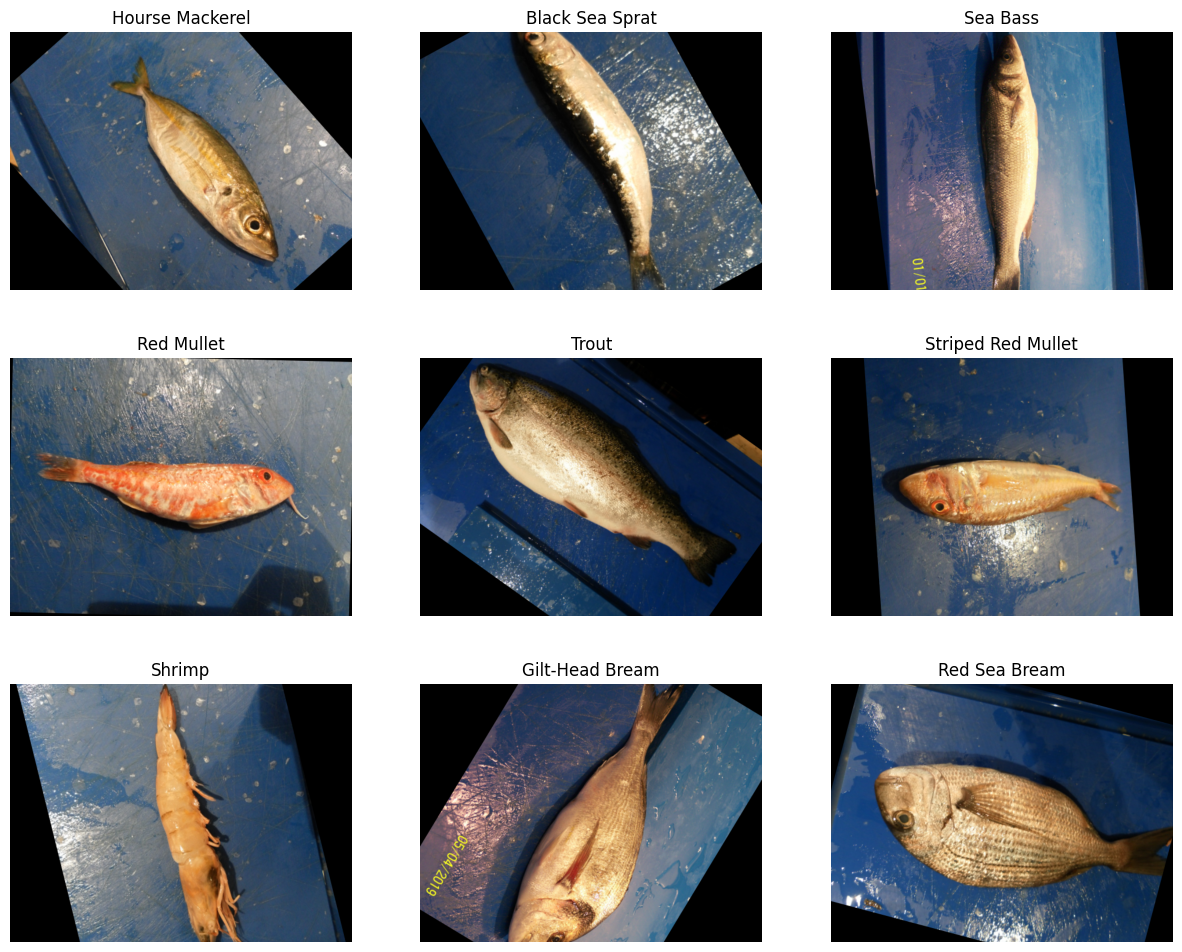

In [37]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [38]:
#Creating the test train split with shuffle
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [39]:
#Checking the shaoe of the newly obtained data
print(train_df.shape)
print(test_df.shape)

(7200, 2)
(1800, 2)


In [40]:
#Using Keras Image Data Generator to preprocess our images with the model we wish to use
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [41]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [42]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

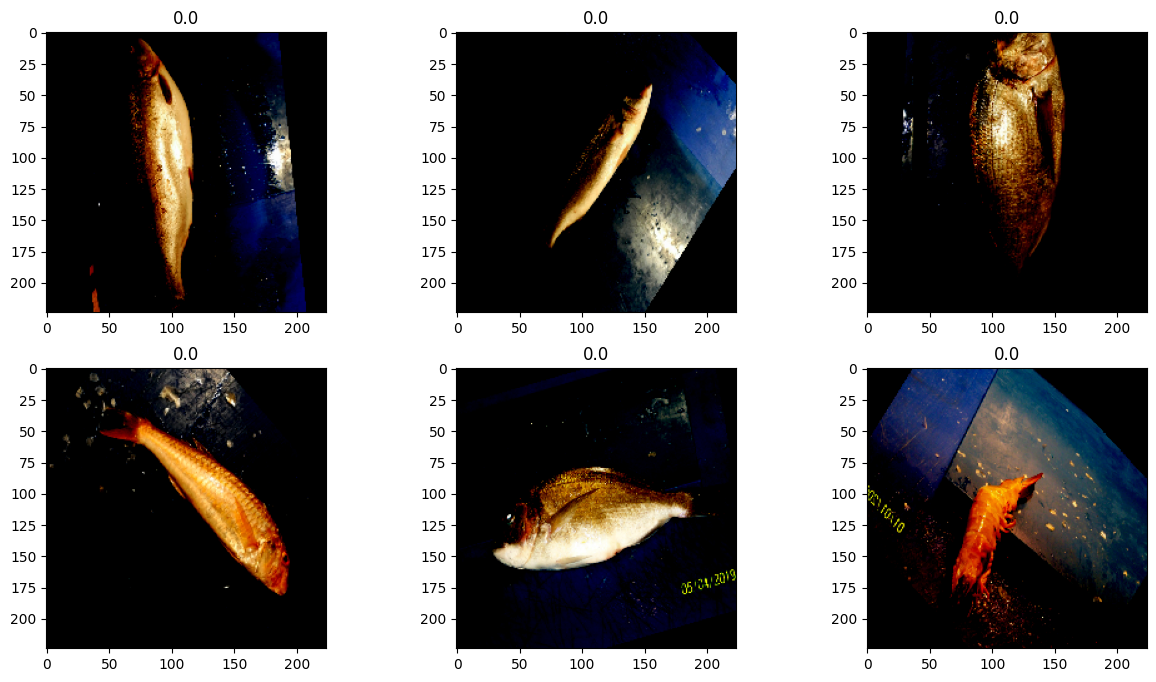

In [52]:
#Plotting images after pre-processing

fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = test_images.__next__()
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0][0])  # modify this line
    j=j+1

In [54]:
#Importing our pretrained model : MobileNetV2

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [56]:
#Creating our model inputs
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,439,625 (9.31 MB)

 Trainable params: 181,641 (709.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8468 - loss: 0.5162 - val_accuracy: 0.9958 - val_loss: 0.0176
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9983 - loss: 0.0110 - val_accuracy: 0.9951 - val_loss: 0.0157
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9991 - loss: 0.0052 - val_accuracy: 0.9958 - val_loss: 0.0124
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.9958 - val_loss: 0.0116
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 1.0000 - loss: 4.4161e-04 - val_accuracy: 0.9972 - val_loss: 0.0084


In [58]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.00397
Test Accuracy: 99.89%


In [59]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 845ms/step


In [61]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [64]:
# Visualize the pred_df
pred_df=pred_df.reset_index(drop=True)
pred_df.head(10)

,path,label,pred
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Gilt-Head Bream,Gilt-Head Bream
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Black Sea Sprat,Black Sea Sprat
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout,Trout
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
5,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
6,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet,Striped Red Mullet
7,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream,Red Sea Bream
8,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Mullet,Red Mullet
9,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Trout,Trout


In [65]:
# Incorrect prediction
pred_df[pred_df['label']!=pred_df['pred']]

,path,label,pred
1604,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet,Shrimp
1629,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Striped Red Mullet,Shrimp


In [75]:
pred_df.path[34]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00088.png'

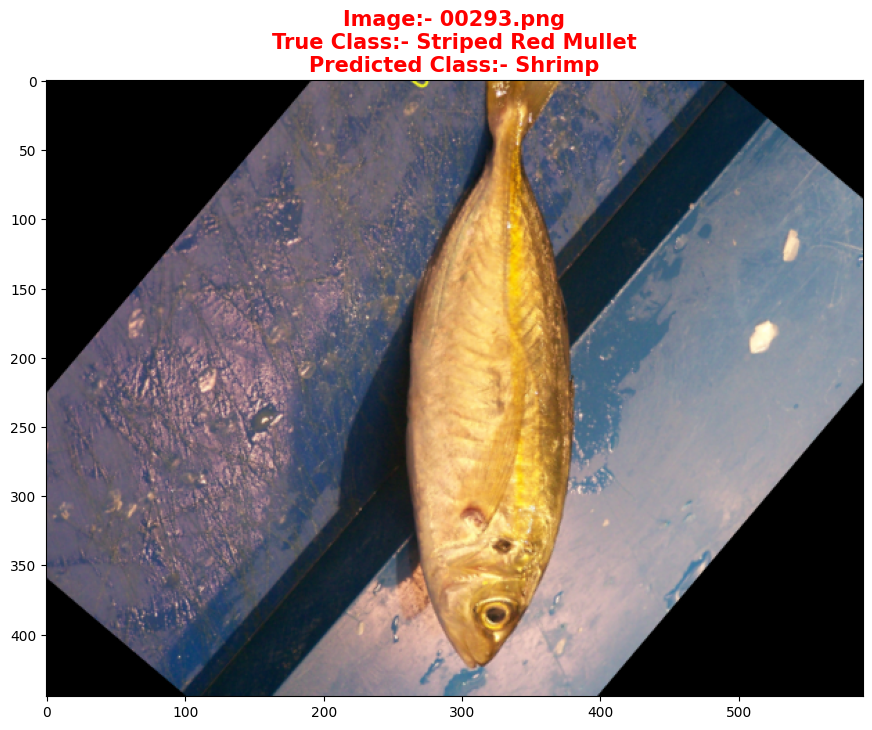

In [76]:
# Which image was it?
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[34]))
title1 = pred_df.path[1604].split('/')[-2]
title2 = pred_df.path[1604].split('/')[-1]
title3 = pred_df.pred[1604]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

Accuracy Score: 0.9988888888888889


<Axes: >

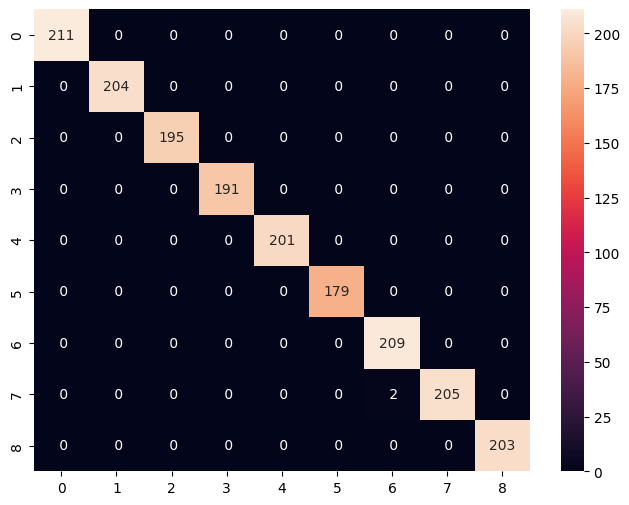

In [77]:
#Checking the accuracy score and creating a Confusion Matrix
print(f"Accuracy Score: {accuracy_score(pred_df['label'],pred_df['pred'])}")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred_df['label'],pred_df['pred']), annot=True, fmt='2d')

In [78]:
#Generating the Classification Report for in-depth analysis
print(classification_report(pred_df['label'],pred_df['pred']))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       211
   Gilt-Head Bream       1.00      1.00      1.00       204
   Hourse Mackerel       1.00      1.00      1.00       195
        Red Mullet       1.00      1.00      1.00       191
     Red Sea Bream       1.00      1.00      1.00       201
          Sea Bass       1.00      1.00      1.00       179
            Shrimp       0.99      1.00      1.00       209
Striped Red Mullet       1.00      0.99      1.00       207
             Trout       1.00      1.00      1.00       203

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800

